In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import ETFs as etfs

In [41]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
display(data)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [42]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)

In [43]:
test_df = pd.DataFrame({'Close_yesterday': data['SPY'].shift(1),'Close Tody':data['SPY'],'Target': binary_targets['SPY']})
display(test_df)

,Close_yesterday,Close Tody,Target
Date,,,
2012-01-03,NaN,100.450684,0
2012-01-04,100.450684,100.608261,1
2012-01-05,100.608261,100.876129,1
2012-01-06,100.876129,100.616127,0
2012-01-09,100.616127,100.860359,1
...,...,...,...
2025-03-24,563.979980,574.080017,1
2025-03-25,574.080017,575.460022,1
2025-03-26,575.460022,568.590027,0


In [44]:
def create_X_y(data,target_label, window_size):
    X, y, labels, first_prices = [], [], [], []
    print(len(data), window_size)
    for i in range(len(data) - window_size):
        window = data.iloc[i : i + window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value
        X.append(normalized_window.values.flatten()) 


        y_target = data.iloc[i + window_size]/ first_value
        y.append(y_target.values) 
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
        
        first_prices.append(first_value)
        
    X = np.array(X)
    y = np.array(y)
    first_prices = np.array(first_prices)
    labels = np.array(labels)
        
    return X, y, first_prices, labels


In [45]:
window_size = 30
dataset_size = len(data)
train_size = int(dataset_size * 0.8)
test_size = int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

binary_targets_train = binary_targets.iloc[:train_size]
binary_targets_val = binary_targets.iloc[train_size:train_size + val_size]
binary_targets_test = binary_targets.iloc[train_size + val_size:]


X_train, y_train, first_values_train, labels_train = create_X_y(train_data, binary_targets_train, window_size)
X_val, y_val, first_values_val, labels_val = create_X_y(val_data, binary_targets_val, window_size)
X_test, y_test, first_values_test, labels_test = create_X_y(test_data, binary_targets_test, window_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, labels_train.shape, labels_val.shape, labels_test.shape

2726 30
342 30
340 30


((2696, 990),
 (2696, 33),
 (312, 990),
 (312, 33),
 (310, 990),
 (310, 33),
 (2696, 33),
 (312, 33),
 (310, 33))

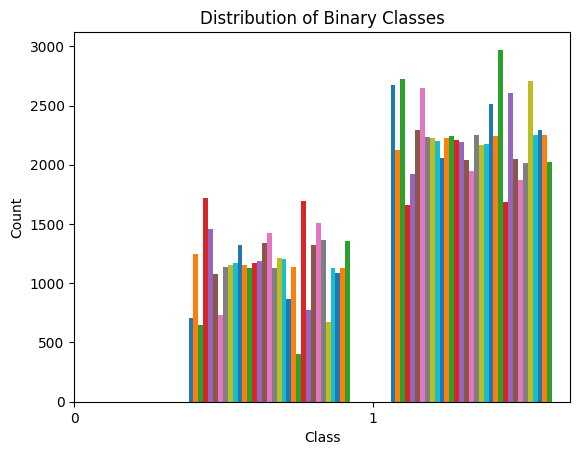

In [46]:
plt.hist(y, bins=2, rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Binary Classes')
plt.show()

In [47]:
rf = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=100,      
        max_depth=10,         
        min_samples_split=2,  
        random_state=42,
        class_weight='balanced',  
        n_jobs=-1
    )
)
rf.fit(X_train, labels_train)


,estimator,RandomForestC...ndom_state=42)
,n_jobs,None
,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [48]:
Y_pred = rf.predict(X_test)
y_pred_df = pd.DataFrame(Y_pred, columns=data.columns)
display(y_pred_df)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
0,1,0,1,0,1,0,1,1,0,1,...,0,1,0,1,0,1,1,1,0,1
1,1,1,1,0,1,0,0,1,0,1,...,0,1,0,1,0,1,0,1,1,0
2,1,0,1,0,1,0,1,1,0,1,...,0,1,1,1,0,1,1,0,0,0
3,1,0,0,0,1,0,1,0,0,1,...,0,1,1,1,0,1,0,0,0,0
4,1,0,0,0,1,0,1,1,0,0,...,0,1,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,1,0,1,1,0
306,0,0,0,1,1,1,0,0,1,0,...,1,1,0,1,0,0,0,1,1,1
307,0,0,0,0,1,1,0,0,1,0,...,1,1,0,1,1,1,0,0,1,1
308,0,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,1,1,0,0,1


In [49]:
from sklearn.metrics import accuracy_score

actual_flat = labels_test.flatten()
predicted_flat = Y_pred.flatten()

accuracy = accuracy_score(actual_flat, predicted_flat)

print(f"Accuracy: {accuracy:.4f}")



Accuracy: 0.4987


In [50]:

overall_accuracy = accuracy_score(actual_flat, predicted_flat)
overall_precision = precision_score(actual_flat, predicted_flat, average='macro', zero_division=0)
overall_recall = recall_score(actual_flat, predicted_flat, average='macro', zero_division=0)
overall_f1 = f1_score(actual_flat, predicted_flat, average='macro', zero_division=0)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision (macro): {overall_precision:.4f}")
print(f"Overall Recall (macro): {overall_recall:.4f}")
print(f"Overall F1 Score (macro): {overall_f1:.4f}")





Overall Accuracy: 0.4987
Overall Precision (macro): 0.4986
Overall Recall (macro): 0.4986
Overall F1 Score (macro): 0.4985


In [51]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    confusion_matrix
)

# For binary classification
accuracy = accuracy_score(actual_flat, predicted_flat)
precision = precision_score(actual_flat, predicted_flat)
recall = recall_score(actual_flat, predicted_flat)
f1 = f1_score(actual_flat, predicted_flat)
roc_auc = roc_auc_score(actual_flat, predicted_flat)  # y_prob is the predicted probability for the positive class
cm = confusion_matrix(actual_flat, predicted_flat)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4}")
print(f"Confusion Matrix:\n{cm}")


Accuracy: 0.4987
Precision: 0.5108
Recall: 0.5053
F1 Score: 0.5081
AUC-ROC: 0.4986
Confusion Matrix:
[[2454 2536]
 [2592 2648]]


In [52]:
labels_test_df = pd.DataFrame(labels_test, columns=data.columns)


In [53]:
yesterday_prices = data.iloc[-2]
today_prices_actual = data.iloc[-1]

num_ones_per_col = (y_pred_df == 1).sum(axis=0)
num_zeros_per_col = (y_pred_df == 0).sum(axis=0)

y_pred_mean_series = (num_ones_per_col > num_zeros_per_col).astype(int)
y_pred_mean = pd.DataFrame([y_pred_mean_series])

today_target_true = labels_test_df.iloc[-1]

comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_actual_target': today_target_true,
    'Today_pred_target': y_pred_mean.loc[0]
})

tickers_names = data.columns

correct_list = []
for ticker in tickers_names:
    predict = y_pred_mean.loc[0, ticker]
    actual = today_target_true[ticker]
    correct_list.append(int(predict == actual))

comparison_df['Correct'] = correct_list

count_of_ones = sum(correct_list)
accuracy = count_of_ones / len(correct_list)

print(f"Count of correct predictions: {count_of_ones}")
print(f"Accuracy: {accuracy:.4f}")

display(comparison_df)


Count of correct predictions: 15


Accuracy: 0.4545


,Yesterday_actual,Today_actual,Today_actual_target,Today_pred_target,Correct
AIEQ,37.658001,36.845001,0,1,0
ASHR.L,10.460000,10.340000,0,1,0
BCHN.L,97.080002,92.714996,0,1,0
CORN,18.510000,18.459999,0,0,1
DBO,14.130000,13.970000,0,1,0
EDEN,105.330002,105.169998,0,0,1
EMXC,56.110001,55.180000,0,1,0
EWA,23.750000,23.469999,0,1,0
EWC,41.250000,40.570000,0,0,1
EWG,37.590000,37.389999,0,0,1
